# Predicting Winner of SUPER BOWL using ML Models

In [ ]:
##Python
#MachineLearning
#FeatureEngineering
#XGBoost
#DataScience
#PredictiveModeling
#SportsAnalytics

In [2]:
%pip install nfl_data_py pandas numpy scikit-learn xgboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 36.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 685.9/685.9 kB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 30.4 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pandas
    Found existing installation: pandas 2.1.4
    Uninstalling pandas-2.1.4:
      Successfully uninstalled pandas-2.1.4
Note: you may need to restart the kernel to use updated packages.


In [3]:
#Python #Pandas #NumPy #ScikitLearn #XGBoost #SportsAnalytics #DataScience

# !pip install nfl_data_py pandas numpy scikit-learn xgboost

import nfl_data_py as nfl
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

import xgboost as xgb


## aggregating  datasets from nfl sources

In [25]:
 

SEASON = 2025         
START_SEASON = 2009
years = list(range(START_SEASON, SEASON + 1))

print(f"Downloading play-by-play and schedules from {START_SEASON} to {SEASON}...")

pbp = nfl.import_pbp_data(years=years, downcast=True)
schedules = nfl.import_schedules(years=years)

print("Plays:", len(pbp))
print("Games:", pbp["game_id"].nunique())
print("Schedules rows:", len(schedules))


2009 done.
2010 done.
2011 done.
2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
2024 done.
2025 done.
Downcasting floats.
Plays: 816856
Games: 4630
Schedules rows: 4630


## Building Team game stats from play by play

In [5]:


team_games = (
    pbp.groupby(["game_id", "posteam"])
    .agg(
        points=("posteam_score", "max"),
        epa=("epa", "mean"),
        success=("success", "mean"),
        turnovers=("interception", "sum"),
        plays=("play_id", "count"),
    )
    .reset_index()
)

team_games.rename(columns={"posteam": "team"}, inplace=True)
team_games = team_games[(team_games["team"].notna()) & (team_games["team"] != "")]

team_games.head()


,game_id,team,points,epa,success,turnovers,plays
0,2009_01_BUF_NE,BUF,24.0,0.072235,0.471429,0.0,71
1,2009_01_BUF_NE,NE,25.0,0.041521,0.537634,1.0,93
2,2009_01_CHI_GB,CHI,15.0,-0.147651,0.430233,4.0,86
3,2009_01_CHI_GB,GB,21.0,-0.104264,0.400000,0.0,76
4,2009_01_DAL_TB,DAL,34.0,0.373225,0.485294,0.0,69


## Creating Winning Labels

In [6]:


team_games = team_games.merge(
    schedules[["game_id", "home_team", "away_team", "home_score", "away_score", "game_type"]],
    on="game_id",
    how="left",
)

def get_win(row):
    if pd.isna(row["home_score"]) or pd.isna(row["away_score"]):
        return np.nan
    if row["team"] == row["home_team"]:
        return int(row["points"] > row["away_score"])
    return int(row["points"] > row["home_score"])

team_games["win"] = team_games.apply(get_win, axis=1)
team_games = team_games.dropna(subset=["win"])

team_games[["game_id","team","points","home_team","away_team","home_score","away_score","win"]].head(10)


,game_id,team,points,home_team,away_team,home_score,away_score,win
0,2009_01_BUF_NE,BUF,24.0,NE,BUF,25,24,0
1,2009_01_BUF_NE,NE,25.0,NE,BUF,25,24,1
2,2009_01_CHI_GB,CHI,15.0,GB,CHI,21,15,0
3,2009_01_CHI_GB,GB,21.0,GB,CHI,21,15,1
4,2009_01_DAL_TB,DAL,34.0,TB,DAL,21,34,1
5,2009_01_DAL_TB,TB,20.0,TB,DAL,21,34,0
6,2009_01_DEN_CIN,CIN,7.0,CIN,DEN,7,12,0
7,2009_01_DEN_CIN,DEN,12.0,CIN,DEN,7,12,1
8,2009_01_DET_NO,DET,27.0,NO,DET,45,27,0
9,2009_01_DET_NO,NO,45.0,NO,DET,45,27,1


## checking index 

In [26]:

team_games["game_id"].str[:4].value_counts().sort_index()


2009    534
2010    534
2011    534
2012    534
2013    534
2014    534
2015    534
2016    534
2017    534
2018    534
2019    534
2020    538
2021    570
2022    568
2023    570
2024    570
2025    570
Name: game_id, dtype: int64

## Capturing momentum of each team.

In [8]:


ROLL_N = 5
team_games = team_games.sort_values(["team", "game_id"])

for col in ["points", "epa", "success", "turnovers"]:
    team_games[f"{col}_rolling"] = (
        team_games.groupby("team")[col]
        .transform(lambda x: x.rolling(ROLL_N, min_periods=1).mean().shift(1))
    )

team_games[["team","game_id","points","points_rolling","epa","epa_rolling"]].head(15)


,team,game_id,points,points_rolling,epa,epa_rolling
24,ARI,2009_01_SF_ARI,16.0,NaN,-0.157113,NaN
32,ARI,2009_02_ARI_JAX,31.0,16.00,0.110672,-0.157113
76,ARI,2009_03_IND_ARI,10.0,23.50,-0.173930,-0.023220
132,ARI,2009_05_HOU_ARI,28.0,19.00,-0.012722,-0.073457
152,ARI,2009_06_ARI_SEA,27.0,21.25,0.010967,-0.058273
180,ARI,2009_07_ARI_NYG,24.0,22.40,-0.063283,-0.044425
208,ARI,2009_08_CAR_ARI,21.0,24.00,-0.154984,-0.025659
232,ARI,2009_09_ARI_CHI,41.0,22.00,0.276926,-0.078790
284,ARI,2009_10_SEA_ARI,31.0,28.20,0.142701,0.011381
288,ARI,2009_11_ARI_STL,21.0,28.80,0.035143,0.042465


## Creating Game Difference Training Datasets 

In [9]:


games = []

for game_id, g in team_games.groupby("game_id"):
    if len(g) != 2:
        continue

    t1, t2 = g.iloc[0], g.iloc[1]

    # skip if rolling features missing
    if pd.isna(t1["epa_rolling"]) or pd.isna(t2["epa_rolling"]):
        continue

    t1_net = t1["points_rolling"] - t2["points_rolling"]
    t2_net = t2["points_rolling"] - t1["points_rolling"]

    games.append(
        {
            "pts_diff": t1["points_rolling"] - t2["points_rolling"],
            "epa_diff": t1["epa_rolling"] - t2["epa_rolling"],
            "success_diff": t1["success_rolling"] - t2["success_rolling"],
            "turnover_diff": t1["turnovers_rolling"] - t2["turnovers_rolling"],

            "t1_epa": t1["epa_rolling"],
            "t2_epa": t2["epa_rolling"],
            "t1_success": t1["success_rolling"],
            "t2_success": t2["success_rolling"],

            # simple proxy (your screenshots had these in the features)
            "def_epa_diff": (t1["epa_rolling"] - t2["epa_rolling"]) * 0.5,
            "pts_allowed_diff": t2["points_rolling"] - t1["points_rolling"],

            "sacks_diff": 0.0,
            "net_pts_diff": t1_net - t2_net,

            "winner": int(t1["win"]),
        }
    )

games_df = pd.DataFrame(games).dropna()
print("Training samples:", len(games_df))
games_df.head()


Training samples: 4614


,pts_diff,epa_diff,success_diff,turnover_diff,t1_epa,t2_epa,t1_success,t2_success,def_epa_diff,pts_allowed_diff,sacks_diff,net_pts_diff,winner
0,4.0,-0.093075,-0.043956,2.0,-0.157113,-0.064038,0.384615,0.428571,-0.046537,-4.0,0.0,8.0,1
1,13.0,0.000754,0.044139,0.0,0.099121,0.098367,0.514019,0.469880,0.000377,-13.0,0.0,26.0,1
2,9.0,0.357203,0.029734,-5.0,-0.134627,-0.491830,0.378049,0.348315,0.178601,-9.0,0.0,18.0,1
3,-14.0,-0.016942,0.035897,2.0,-0.121206,-0.104264,0.435897,0.400000,-0.008471,14.0,0.0,-28.0,1
4,7.0,-0.101988,0.011424,1.0,-0.145814,-0.043827,0.388235,0.376812,-0.050994,-7.0,0.0,14.0,0


## Training XGboost Model

In [28]:


feature_cols = [
    "pts_diff", "epa_diff", "success_diff", "turnover_diff",
    "t1_epa", "t2_epa", "t1_success", "t2_success",
    "def_epa_diff", "pts_allowed_diff", "sacks_diff", "net_pts_diff"
]

X = games_df[feature_cols]
y = games_df["winner"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss",
)

model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
print("Accuracy:", round(accuracy_score(y_test, y_pred) * 100, 1), "%")


Accuracy: 58.8 %


## Restrict to 2025 games for team profile

In [11]:

team_2025 = team_games[team_games["game_id"].astype(str).str.contains("2025")].copy()

team_avgs = team_2025.groupby("team").agg(
    points=("points", "mean"),
    epa=("epa", "mean"),
    success=("success", "mean"),
    turnovers=("turnovers", "mean"),
    games=("game_id", "count"),
)

# Defense proxies: opponent points + opponent EPA
def_stats = []
for game_id, gd in team_2025.groupby("game_id"):
    if len(gd) != 2:
        continue
    teams = gd["team"].tolist()
    for _, row in gd.iterrows():
        opp = [t for t in teams if t != row["team"]][0]
        opp_row = gd[gd["team"] == opp].iloc[0]
        def_stats.append(
            {"team": row["team"], "pts_allowed": opp_row["points"], "opp_epa": opp_row["epa"]}
        )

def_df = pd.DataFrame(def_stats).groupby("team").agg(
    pts_allowed=("pts_allowed", "mean"),
    def_epa=("opp_epa", lambda x: -x.mean()),
)

# Sacks per game from pbp
pbp_2025 = pbp[pbp["game_id"].astype(str).str.contains("2025")].copy()

if "sack" in pbp_2025.columns and "defteam" in pbp_2025.columns:
    sacks_df = (
        pbp_2025[pbp_2025["sack"] == 1]
        .groupby(["game_id", "defteam"])
        .size()
        .reset_index(name="sack")
    )
    sacks_avg = sacks_df.groupby("defteam")["sack"].mean().rename("sacks")
else:
    sacks_avg = pd.Series(dtype=float, name="sacks")

team_avgs = team_avgs.join(def_df).join(sacks_avg)
team_avgs["sacks"] = team_avgs["sacks"].fillna(0)

team_avgs.loc[["SEA","NE"]]


,points,epa,success,turnovers,games,pts_allowed,def_epa,sacks
team,,,,,,,,
SEA,29.049999,0.075266,0.504411,0.750000,20,16.600000,0.124418,3.111111
NE,26.238094,0.063228,0.482651,0.571429,21,17.761906,0.068140,2.400000


## Predicting SeaHawks vs Patriots |XGboost model vs  Point Difference model

In [12]:


SEA = team_avgs.loc["SEA"]
NE  = team_avgs.loc["NE"]

sea_net = SEA["points"] - SEA["pts_allowed"]
ne_net  = NE["points"]  - NE["pts_allowed"]

# Build SB input row (same style as screenshots)
sb_features = pd.DataFrame([{
    "pts_diff": SEA["points"] - NE["points"],
    "epa_diff": SEA["epa"] - NE["epa"],
    "success_diff": SEA["success"] - NE["success"],
    "turnover_diff": SEA["turnovers"] - NE["turnovers"],
    "t1_epa": SEA["epa"],
    "t2_epa": NE["epa"],
    "t1_success": SEA["success"],
    "t2_success": NE["success"],
    "def_epa_diff": (SEA["def_epa"] - NE["def_epa"]) * 2.0,
    "pts_allowed_diff": (SEA["pts_allowed"] - NE["pts_allowed"]) * 2.0,
    "sacks_diff": (SEA["sacks"] - NE["sacks"]) * 2.0,
    "net_pts_diff": (sea_net - ne_net) * 2.0,
}])

sb_scaled = scaler.transform(sb_features[feature_cols])
prob = model.predict_proba(sb_scaled)[0]
xgb_sea = prob[1]
xgb_ne  = prob[0]

# Point differential win probability (logistic with base-10 like screenshot)
spread = sea_net - ne_net
pt_diff_sea = 1 / (1 + 10 ** (-spread / 7))
pt_diff_ne = 1 - pt_diff_sea

# Blend (40% XGB + 60% point diff)
sea_prob = 0.4 * xgb_sea + 0.6 * pt_diff_sea
ne_prob = 1 - sea_prob

print("Model breakdown:")
print(f"XGBoost:    SEA {xgb_sea*100:.1f}% | NE {xgb_ne*100:.1f}%")
print(f"Point diff: SEA {pt_diff_sea*100:.1f}% | NE {pt_diff_ne*100:.1f}%")
print("\nFinal (40/60 blend):")
print(f"Seahawks:  {sea_prob*100:.1f}%")
print(f"Patriots:  {ne_prob*100:.1f}%")
print("\nWinner:", "SEAHAWKS" if sea_prob > ne_prob else "PATRIOTS")


Model breakdown:
XGBoost:    SEA 83.5% | NE 16.5%
Point diff: SEA 78.7% | NE 21.3%

Final (40/60 blend):
Seahawks:  80.6%
Patriots:  19.4%

Winner: SEAHAWKS


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Extract season + week from game_id like "2009_01_BUF_NE"
team_games["season"] = team_games["game_id"].str[:4].astype(int)
team_games["week"] = team_games["game_id"].str.extract(r'_(\d{2})_').astype(int)

# Make a sortable time index (season-week)
team_games["season_week"] = team_games["season"] * 100 + team_games["week"]

# Proper chronological sort
team_games = team_games.sort_values(["team", "season", "week"]).reset_index(drop=True)


## plotting seasons only for Teams SEA|NE

In [27]:

TEAMS = ["SEA", "NE"]
PLOT_FROM_SEASON = 2021  

plot_df = team_games[
    (team_games["team"].isin(TEAMS)) &
    (team_games["season"] >= PLOT_FROM_SEASON)
].copy()

# Quick sanity check
plot_df.groupby("team")[["season","week"]].tail(1)


,season,week
6359,2025,22
8106,2025,22


## Plotting rolling points to see Momentum 

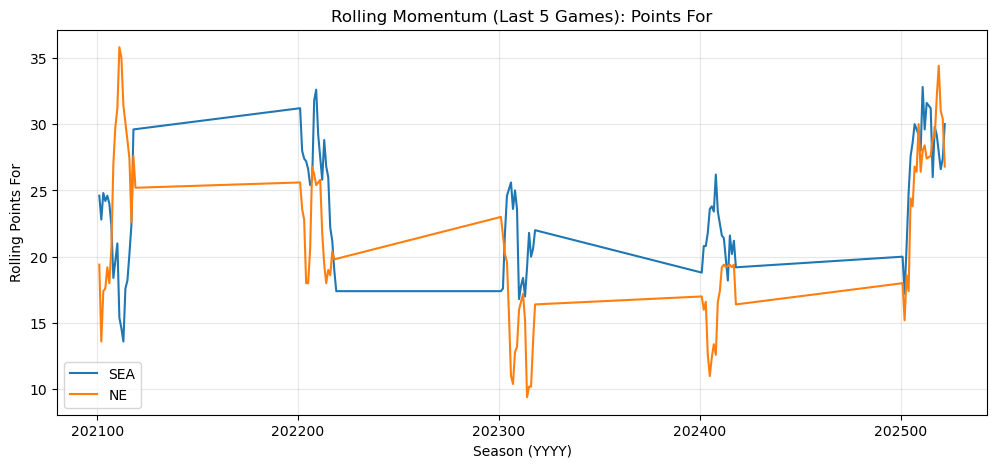

In [23]:

plt.figure(figsize=(12, 5))

for t in TEAMS:
    tmp = plot_df[plot_df["team"] == t].sort_values(["season", "week"])
    plt.plot(tmp["season_week"], tmp["points_rolling"], label=t)


plt.title(f"Rolling Momentum (Last {ROLL_N} Games): Points For")
plt.xlabel("Season (YYYY)")
plt.ylabel("Rolling Points For")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



## Plotting rolling EPA Momentum 

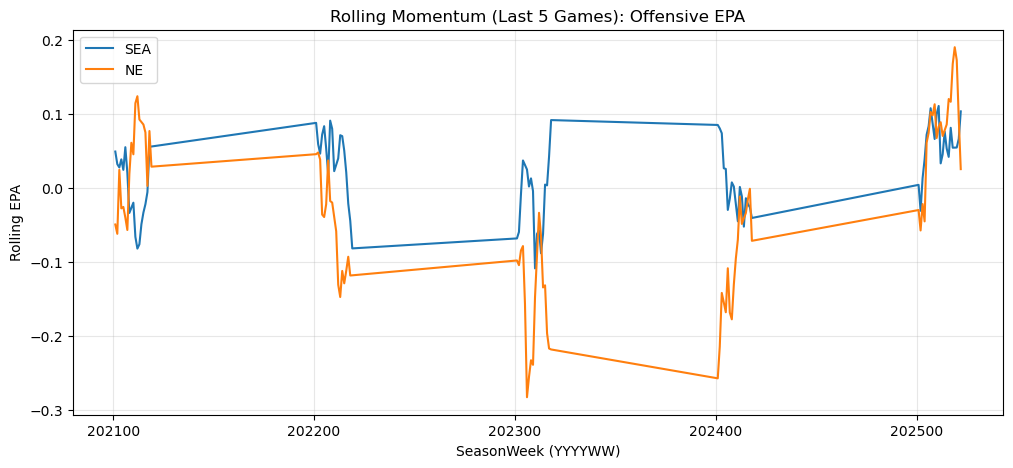

In [20]:
plt.figure(figsize=(12, 5))

for t in TEAMS:
    tmp = plot_df[plot_df["team"] == t].sort_values(["season", "week"])
    plt.plot(tmp["season_week"], tmp["epa_rolling"], label=t)

plt.title(f"Rolling Momentum (Last {ROLL_N} Games): Offensive EPA")
plt.xlabel("SeasonWeek (YYYYWW)")
plt.ylabel("Rolling EPA")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## calculating Success rolling momentum

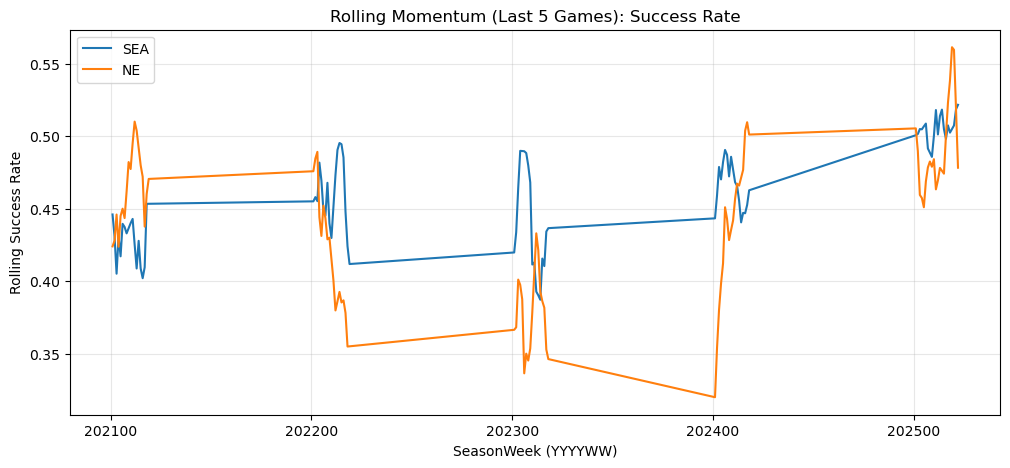

In [21]:
 
plt.figure(figsize=(12, 5))

for t in TEAMS:
    tmp = plot_df[plot_df["team"] == t].sort_values(["season", "week"])
    plt.plot(tmp["season_week"], tmp["success_rolling"], label=t)

plt.title(f"Rolling Momentum (Last {ROLL_N} Games): Success Rate")
plt.xlabel("SeasonWeek (YYYYWW)")
plt.ylabel("Rolling Success Rate")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## plotting Rolling turnovers

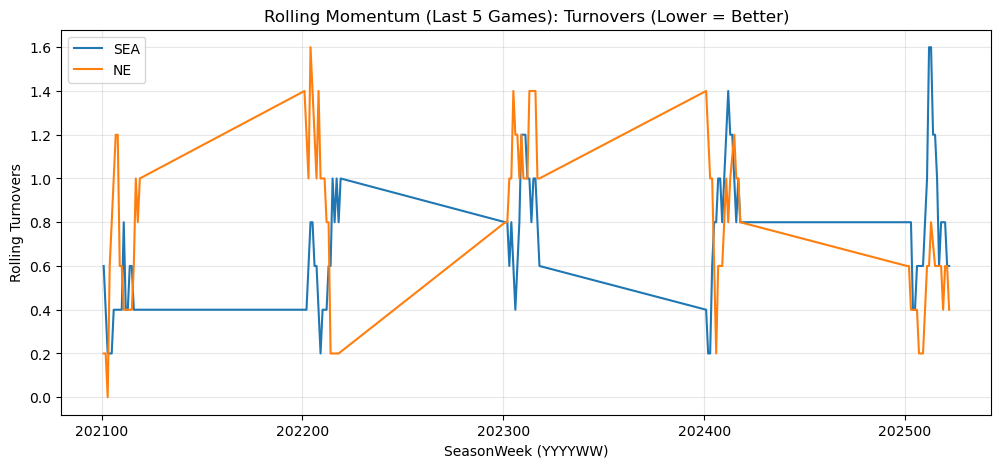

In [24]:
 
plt.figure(figsize=(12, 5))

for t in TEAMS:
    tmp = plot_df[plot_df["team"] == t].sort_values(["season", "week"])
    plt.plot(tmp["season_week"], tmp["turnovers_rolling"], label=t)

plt.title(f"Rolling Momentum (Last {ROLL_N} Games): Turnovers (Lower = Better)")
plt.xlabel("SeasonWeek (YYYYWW)")
plt.ylabel("Rolling Turnovers")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
